# A mini Machine Learning Project exploring feature and model selection

This code will:    
- downloads the data    
- performs necessary data cleaning and wrangling
- performs some EDA (creates at least one table and one visualization)
- performs feature and model selection (you should create at least one table and one visualization to present these results)

## 1. Preprocessing:

- The data can be found from this [link](http://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data#) of **UCI**
- After download and unzip the file, choose the 3year.arff file as the data file only. 
- This data contains financial rates from 3rd year of the forecasting period and corresponding class label that indicates bankruptcy status after 3 years. The data contains 10503 instances (financial statements), 495 represents bankrupted companies, 10008 firms that did not bankrupt in the forecasting period. 

In [1]:
# Loading all needed library

from scipy.io import arff
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import Imputer
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
# Importing data
data = arff.loadarff('../data/3year.arff')
df = pd.DataFrame(data[0])

# Take a glance at the dataset:
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


## 2. Data Wrangling

### Replacing feature *class* into a binary label
> It can be seen that the last column contains the label of each company whether it was bankrupt in the forecasting period or not. I want to transform it into binary label which will be easier to handle than character labels.

The new label will be:
- 0: represents firms that did not bankrupt in the forecasting period        
- 1: represents bankrupted companies

In [3]:
df['bankrupt'] = df['class'].map({b'0':0, b'1':1})
# After replacing, remove the unused feature
df.drop('class',axis=1,inplace=True)
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,bankrupt
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


Preliminary examination of the dataset:

In [4]:
# 495 represents bankrupted companies, 10008 firms that did not bankrupt in the forecasting period. 

print(df.shape[0],"number of observation/ instances (financial statements)")
print(df.shape[1],"number of features")
print(df['bankrupt'].value_counts()[0],"firms that did not bankrupt in the forecasting period")
print(df['bankrupt'].value_counts()[1],"bankrupted companies")

10503 number of observation/ instances (financial statements)
65 number of features
10008 firms that did not bankrupt in the forecasting period
495 bankrupted companies


### Missing data
The data repository makes a note that there are missing values in this dataset, so I will take a look at how bad the situation is:

In [5]:
# Explore the missing data:
for i in list(df):
    print(i,"has {0} missing value(s)".format(df[df[i].isnull()].shape[0]))

Attr1 has 0 missing value(s)
Attr2 has 0 missing value(s)
Attr3 has 0 missing value(s)
Attr4 has 18 missing value(s)
Attr5 has 25 missing value(s)
Attr6 has 0 missing value(s)
Attr7 has 0 missing value(s)
Attr8 has 14 missing value(s)
Attr9 has 3 missing value(s)
Attr10 has 0 missing value(s)
Attr11 has 0 missing value(s)
Attr12 has 18 missing value(s)
Attr13 has 43 missing value(s)
Attr14 has 0 missing value(s)
Attr15 has 8 missing value(s)
Attr16 has 14 missing value(s)
Attr17 has 14 missing value(s)
Attr18 has 0 missing value(s)
Attr19 has 43 missing value(s)
Attr20 has 43 missing value(s)
Attr21 has 807 missing value(s)
Attr22 has 0 missing value(s)
Attr23 has 43 missing value(s)
Attr24 has 227 missing value(s)
Attr25 has 0 missing value(s)
Attr26 has 14 missing value(s)
Attr27 has 715 missing value(s)
Attr28 has 228 missing value(s)
Attr29 has 0 missing value(s)
Attr30 has 43 missing value(s)
Attr31 has 43 missing value(s)
Attr32 has 101 missing value(s)
Attr33 has 18 missing valu

There's no missing label, which is a good sign. However, there are many attributes that have missing data. It's better to exclude feature that has more than 20% missing values: Attribute 37. Other features that have missing values will be imputed later in the modeling process.

In [6]:
# Excluding Attr37 which has 4736 missing values (47% data lost)
df.drop('Attr37',axis=1,inplace=True)

## 3. Exploratory data analysis (EDA)

First, we will take a look at some statistic of all features since all 64 features are continuous values.

In [7]:
df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,bankrupt
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,...,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,...,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800,0.047129
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,...,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,...,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,...,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.000000,0.050945,1.111000,1.199000,0.515500,...,0.051765,0.106880,0.953060,0.002976,9.952100e+00,6.677300,7.066400e+01,5.139200,4.059300,0.000000
75%,0.123805,0.689330,0.419545,2.959500,5.608400e+01,0.072584,0.142275,2.857100,2.059100,0.725635,...,0.130010,0.271310,0.995927,0.240320,2.093600e+01,10.587500,1.182200e+02,8.882600,9.682750,0.000000
max,52.652000,480.730000,17.708000,53433.000000,6.854400e+05,45.533000,52.652000,53432.000000,740.440000,11.837000,...,293.150000,552.640000,18118.000000,7617.300000,3.660200e+06,4470.400000,1.073500e+06,1974.500000,21499.000000,1.000000


Then we will take a look at the differences between two groups (bankrupt and not bankrupt companies) with regards to three important features:
- Attr4: current assets / short-term liabilities
- Attr17: total assets / total liabilities  
- Attr23: net profit / sales

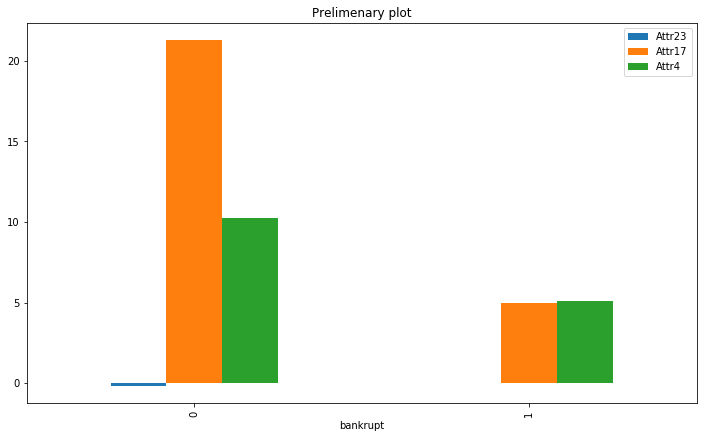

In [8]:
df.groupby(["bankrupt"])["Attr23","Attr17","Attr4"].mean().plot(kind="bar",title="Prelimenary plot",figsize=(12,7))

It can be seen that the group of non-bankrupt companies has higher values in all three features. Feature 4 calculates the current ratio between current asset and current liability which shows the bankruptcy potential in short term. The lower the ratio, the higher chance the the company will go bankrupt in short term. This features is not much different between two groups.
Feature 17 is the leverage ratio showing how much capital comes in the form of debt. The lower the ratio the more debt that company keeps compared with its asset. This is a really bad sign and it is shown clearly in the plot that companies that are going to bankrupt have much lower values in this category.
Feature 23 represents the profit margin of a company. Companies in bankrupt group does not have much value in this category.

## 4. Feature and model selection

This dataset has a few missing values so I will need to do some preprocessing to impute the missing values with the mean of each features. This is not an ideal way but it won't affect the result much since the number of missing values is relatively small (less than 10% for each feature that has missing values).

In [9]:
# Divide the dataset into traning and testing set with labels
X = df.iloc[:,:-1].values
y = df.iloc[:,63].values

# splitting the set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [10]:
#  Imputing the missing values by the mean of the columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_train)

X = imp.transform(X)

# Split again:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

### 1st try out: Logistic Regression


In [11]:
# Setting up
threshold = 1e-6

# Logistic Regression with L1 penalty
clf1 = LogisticRegression(penalty = 'l1')
# Logistic Regression with L1 penalty
clf2 = LogisticRegression(penalty = 'l2')

In [12]:
model_list = (clf1, clf2)

for clf in model_list:
    clf.fit(X_train, y_train)
    feature_weight = clf.coef_
    print("The validation score of model",clf.score(X_test,y_test))
    print("The number of selected feature of model",(np.sum(abs(feature_weight) > threshold)))

The validation score of model 0.954307472632
The number of selected feature of model 49
The validation score of model 0.915278438839
The number of selected feature of model 44


Out of 64 features, the first model chooses 54 features with higher validation score ($0.95$), so we will choose this model. Now I will perform a cross validation to find the best hyperparameter 'C':

In [19]:
listC = 10.0**np.arange(-4,4)
parameter = {'C':listC}
lr = LogisticRegression(penalty = 'l1')
clf = GridSearchCV(lr, parameter)

clf.fit(X_train, y_train)
print("The best parameter is",clf.best_params_)
print("The best score is",clf.best_score_)

The best parameter is {'C': 0.001}
The best score is 0.950964056177


In [20]:
lr = LogisticRegression(penalty = 'l1', C = 0.001)
lr.fit(X_train, y_train)
print("Training score of Logistic Regression model is",lr.score(X_train, y_train))
print("Testing score of Logistic Regression model is",lr.score(X_test, y_test))

Training score of Logistic Regression model is 0.951559152583
Testing score of Logistic Regression model is 0.956211327939


### 2nd try out: Decision Tree Classifier

I will combine the average 10-fold cross-validation scores on the training dataset using sklearn's cross_val_score and the Decision Tree Classifier as the model to find the best estimator for the dataset

In [21]:
maxDepth = 50
kFold = 10
scores = np.zeros((maxDepth, kFold))

for depth in np.arange(1, maxDepth + 1):
    clf = DecisionTreeClassifier(max_depth=depth)
    scores[depth - 1] = cross_val_score(clf, X_train, 
                                        y_train, cv=kFold)

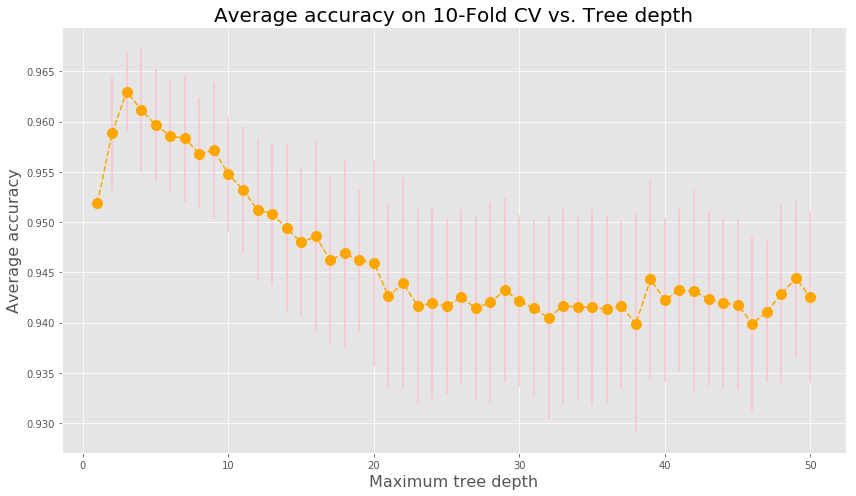

In [25]:
# Plot the results 
# Code from the lab1 solution
plt.style.use('ggplot')
plt.errorbar(range(1, maxDepth + 1), np.average(scores, axis=1), 
             color='orange', linestyle='--', marker='o', markersize=10, 
             yerr=np.std(scores, axis=1), ecolor='pink', 
             capthick=2)
plt.xlabel("Maximum tree depth", fontsize = 16)
plt.ylabel("Average accuracy", fontsize = 16)
plt.title("Average accuracy on 10-Fold CV vs. Tree depth", 
          fontsize = 20)
plt.gcf().set_size_inches(12, 7)
plt.tight_layout()
plt.show()

The cross validation accuracies are very high in general, however we can see that the accuracy decreases when the tree depth increases and is quite stable after depth 20. So if an accuracy above 95% is desired, an estimator from depth $3$ to $14$ is a reasonable choice for this data.          
Now I will try plotting the training and testing score with vs the depth of the tree:

In [26]:
trainging_scores = np.zeros((maxDepth, 1))
testing_scores = np.zeros((maxDepth, 1))

for depth in np.arange(1, maxDepth + 1):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    trainging_scores[depth - 1] = clf.score(X_train, y_train)
    testing_scores[depth - 1] = clf.score(X_test, y_test)

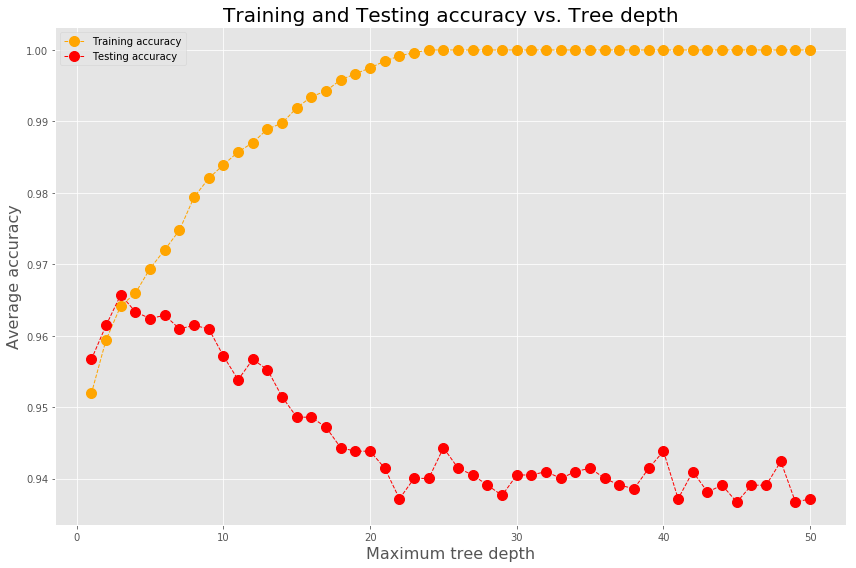

In [28]:
# Plot the results
plt.style.use('ggplot')
plt.plot(range(1, maxDepth + 1), trainging_scores, 'o--', 
         markersize=10, color='orange', lw=1, label='Training accuracy')
plt.plot(range(1, maxDepth + 1), testing_scores, 'o--',
         markersize=10, color='red', lw=1, label='Testing accuracy')
plt.xlabel("Maximum tree depth", fontsize = 16)
plt.ylabel("Average accuracy", fontsize = 16)
plt.title("Training and Testing accuracy vs. Tree depth", 
          fontsize = 20)
plt.legend(loc="best")
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

This is a much more interesting graph. It can be seen that after depth $20$, the model is definitely overfitting. However, the accuracies are relatively high for both training and testing accuracy from the very beginning, so depth from $1$ to $15$ is advisable. Now I will create the model with the parameter chosen from the test above.

In [29]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print("Training score of Decision Tree Classifier is",clf.score(X_train, y_train))
print("Testing score of Decision Tree Classifier is",clf.score(X_test, y_test))

Training score of Decision Tree Classifier is 0.964175196382
Testing score of Decision Tree Classifier is 0.965730604474


### Last try out: A simple ordinary least squares model.

This model will help me see which features is more significant in the dataset by the p-value.

In [30]:
import statsmodels.api as sm
lm = sm.OLS(y_train,X_train).fit()
print(lm.summary())

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     10.35
Date:                Sat, 27 Jan 2018   Prob (F-statistic):           9.75e-92
Time:                        23:38:13   Log-Likelihood:                 1134.0
No. Observations:                8402   AIC:                            -2146.
Df Residuals:                    8341   BIC:                            -1717.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0505      0.073      0.691      0.4

There are two noticable things: First one is that there are many features that has p-value larger than $10$%. The second things is that the warning message saying there might be a strong multicollinearity problems. This is understandable because some ratios in the financial statement are normally correlated. This could be done from the beginning to select the features that are more related and important. 